In [1]:
import torch 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Structure
from cdft.dft3d_pcsaft import dft_core
from cdft.pcsaft_eos import pcsaft

device = torch.device('cuda')

In [2]:
m = torch.tensor([1.0], dtype=torch.float64)
sigma = torch.tensor([3.7039], dtype=torch.float64)
epsilon = torch.tensor([150.03], dtype=torch.float64)
parameters = {'m':m, 'sigma':sigma, 'epsilon':epsilon}

In [3]:
structure = Structure.from_file('structures/IRMOF-1.cif')
print('formula:        ', structure.formula)
print('num_sites:      ', structure.num_sites)
print('lattice_lengths:', structure.lattice.lengths)

formula:         Zn32 H96 C192 O104
num_sites:       424
lattice_lengths: (25.832, 25.832, 25.832)


/home/lucas/miniforge3/envs/torch/lib/python3.12/site-packages/pymatgen/core/structure.py:3107: UserWarning: Issues encountered while parsing CIF: Skipping relative stoichiometry check because CIF does not contain formula keys.
  struct = parser.parse_structures(primitive=primitive)[0]


In [4]:
T = 300.0
system_size = np.array([l for l in structure.lattice.lengths])
points = np.array([64, 64, 64])
dft = dft_core(parameters, T, system_size, points, device)

In [5]:
forcefield = pd.DataFrame()
forcefield['type'] = ['C','H','O','Zn']
forcefield['sigma'] = np.array([3.47299, 2.84642, 3.03315, 4.04468])
forcefield['epsilon'] = np.array([47.8562, 7.64893, 48.1581, 27.6771])

def lj_potential(r,sigma,epsilon):
    return 4.0*epsilon*((sigma/r)**12-(sigma/r)**6) 

rc = 12.9

Vext = torch.zeros((dft.Nc, points[0], points[1], points[2]),device=device,dtype=torch.float64)
U = torch.zeros_like(dft.X)
for i in range(dft.Nc):
    for k, site in enumerate(structure):
        sigmasf = float(0.5*(sigma[i].numpy()+forcefield['sigma'][forcefield['type']==site.species_string]))
        epsilonsf = float(np.sqrt(epsilon[i].numpy()*forcefield['epsilon'][forcefield['type']==site.species_string]))
        rx = dft.X-structure.cart_coords[k,0] 
        ry = dft.Y-structure.cart_coords[k,1] 
        rz = dft.Z-structure.cart_coords[k,2] 
        rx -= system_size[0]*(rx/system_size[0]).round()
        ry -= system_size[1]*(ry/system_size[1]).round()
        rz -= system_size[2]*(rz/system_size[2]).round()
        r = torch.sqrt(rx**2+ry**2+rz**2)
        U = lj_potential(r,sigmasf,epsilonsf)
        U[r==0] = np.inf
        U[r>rc] = 0.0
        Vext[i] += U

/tmp/ipykernel_67622/1011039065.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmasf = float(0.5*(sigma[i].numpy()+forcefield['sigma'][forcefield['type']==site.species_string]))
/tmp/ipykernel_67622/1011039065.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilonsf = float(np.sqrt(epsilon[i].numpy()*forcefield['epsilon'][forcefield['type']==site.species_string]))


Text(0, 0.5, '$y$ (\\AA{})')

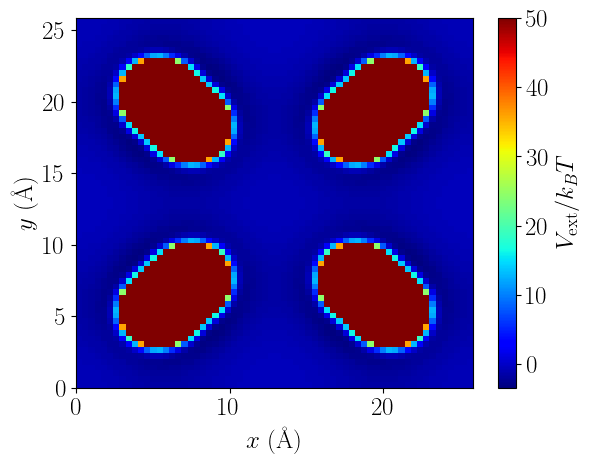

In [6]:
plt.rcParams.update({'text.usetex':True, 
'font.family':'serif', 
'font.size':18, 
# 'axes.linewidth':1.1, 
'lines.linewidth':1.6,
'legend.fontsize': 18,
'legend.frameon':False
#'figure.figsize':(7.9, 6.1)
})


plt.figure()
c=plt.pcolormesh(dft.X[:,:,points[0]//2].cpu(),dft.Y[:,:,points[1]//2].cpu(),Vext[0,:,:,points[2]//2].cpu()/T, vmax=50.0, cmap='jet')
plt.colorbar(label=r'$V_{\mathrm{ext}}/k_B T$')
plt.xlabel(r'$x$ (\AA{})')
plt.ylabel(r'$y$ (\AA{})')

In [7]:
P = torch.hstack((torch.arange(1e4,1e5,1e4,dtype=torch.float64), torch.arange(1e5,1e6,1e5,dtype=torch.float64), 
                  torch.range(1e6,1e7,1e6,dtype=torch.float64)))
bulk_density = torch.empty_like(P)
composition = torch.tensor([1.0],dtype=torch.float64)

eos = pcsaft(parameters, T)
bulk_density[0] = eos.density(P[0],composition,'vap')
for i in range(1,len(P)):
    bulk_density[i] = eos.density(P[i],composition,bulk_density[i-1])

/tmp/ipykernel_67622/1798351369.py:2: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  torch.range(1e6,1e7,1e6,dtype=torch.float64)))


In [8]:
dft.initial_condition(bulk_density[0],composition,Vext)

In [9]:
Nads = torch.empty((dft.Nc,len(P)),dtype=torch.float64)
for i in range(len(P)):
    dft.equilibrium_density_profile(bulk_density[i],composition,fmt='ASWB',solver='anderson',
                                    anderson_mmax=5,anderson_damping=0.1,tol=1e-6,logoutput=False)
    for j in range(dft.Nc):
        Nads[j,i] = dft.total_molecules[j]
    print(dft.it,dft.error.numpy(),1e-5*P[i].numpy(),Nads[:,i].numpy())
    if np.isnan(dft.error.numpy()): break

4 8.764584827300551e-07 0.1 [0.27496796]
6 1.1913715093877266e-08 0.2 [0.55060226]
6 1.1305599941942418e-08 0.30000000000000004 [0.82689489]
6 5.724807484737075e-09 0.4 [1.10383813]
6 1.2921523573372338e-07 0.5 [1.38142406]
6 1.4203573205955996e-07 0.6000000000000001 [1.65964392]
6 1.323489051340075e-07 0.7000000000000001 [1.93849014]
6 1.3425607839237015e-07 0.8 [2.21795384]
5 7.864923941462319e-07 0.9 [2.49802771]
5 5.861550039597335e-07 1.0 [2.7786999]
8 1.3831571366593174e-08 2.0 [5.61635003]
8 2.459216488231515e-08 3.0000000000000004 [8.50302906]
8 6.9067782271546e-08 4.0 [11.42732467]
8 1.5965008633965338e-07 5.0 [14.37664041]
8 3.060337929796059e-07 6.000000000000001 [17.33762266]
7 9.838801457908665e-07 7.000000000000001 [20.29668054]
8 9.98084977042598e-07 8.0 [23.24048358]
11 6.256110932909591e-07 9.0 [26.15654903]
11 9.266628649918374e-08 10.0 [29.03351507]
25 8.82077065442704e-07 20.0 [54.22582651]
25 8.743787229794477e-07 30.000000000000004 [72.2720838]
19 9.02619223683170

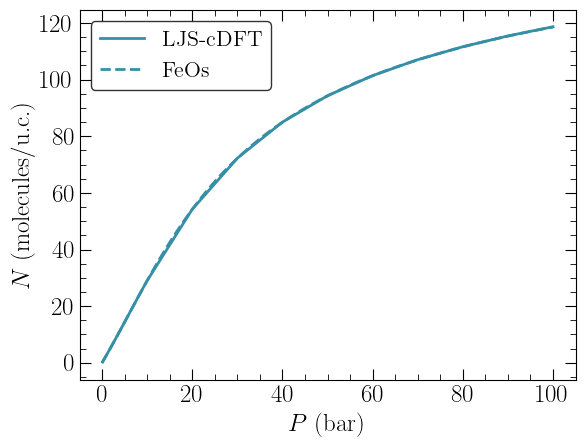

In [11]:
# data = pd.read_pickle(f'data/methane_IRMOF-1_{T:.2f}K.pkl')
feos = np.load('data/feos.npy')

import seaborn as sns

colors = sns.color_palette("mako")

plt.rcParams.update({'text.usetex':True, 
'font.family':'serif',  
#'figure.figsize':(7.9, 6.1)
})

plt.plot(P*1e-5, Nads[0], '-', color=colors[3], linewidth=2.0, label='LJS-cDFT')
plt.plot(feos[0], feos[1], '--', color=colors[3], linewidth=2.0, label='FeOs')
# plt.plot(1e-5*data['Pressure (Pa)'], data['Absolute adsorption (molecules/uc)'], 'o', 
#          color=colors[3],markersize=7,markeredgewidth=1.5,mfc='none',label='GCMC')
plt.xlabel(r'$P$ (bar)', fontsize=18)
plt.ylabel(r'$N$ (molecules/u.c.)', fontsize=18)
# plt.xlim([0.0,125])
# plt.ylim([None,0.004])
plt.minorticks_on()
plt.tick_params(direction='in',right=True, top=True)
plt.tick_params(labelsize=18)
plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
plt.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
plt.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)
plt.legend(fontsize=16, frameon=True, edgecolor='k')
# plt.savefig('figures/isotherm_methane.pdf', bbox_inches='tight')